In [134]:
import pandas as pd
import wget
import shutil
import os
from functools import reduce
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [18]:
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

for url in urls:
    output = url.split('/')[-1]
    filename = wget.download(url, output)
    if os.path.exists(output):
        shutil.move(filename, output)

100% [..............................................................................] 50902 / 50902

In [51]:
conf_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [52]:
dates = conf_df.columns[4:]

conf_df_long = conf_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

deaths_df_long = deaths_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Deaths')

recv_df_long = recv_df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                             value_vars=dates, var_name='Date', value_name='Recovered')

In [53]:
merged1 = conf_df_long.merge(deaths_df_long, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

In [54]:
full_table = merged1.merge(recv_df_long, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

In [55]:
full_table = full_table[full_table['Province/State'].str.contains('Recovered')!=True]

# removing county wise data to avoid double counting
full_table = full_table[full_table['Province/State'].str.contains(',')!=True]

In [56]:
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South', 'South Korea')

In [57]:
feb_12_conf = {'Hubei' : 34874}

In [58]:
def change_val(date, ref_col, val_col, dtnry):
    for key, val in dtnry.items():
        full_table.loc[(full_table['Date']==date) & (full_table[ref_col]==key), val_col] = val

In [59]:
change_val('2/12/20', 'Province/State', 'Confirmed', feb_12_conf)

In [60]:
full_table[(full_table['Date']=='2/12/20') & (full_table['Province/State']=='Hubei')]

Province/State Country/Region      Lat      Long     Date  Confirmed  \
5175          Hubei          China  30.9756  112.2707  2/12/20      34874   

      Deaths  Recovered  
5175    1068       2686

In [65]:
df = full_table.groupby(['Country/Region', 'Date'], as_index=False).sum()

In [73]:
df.drop(columns=['Lat', 'Long'], inplace=True)

In [77]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [80]:
current_date = df['Date'].max()
dff = df[df['Date'].eq(current_date)].sort_values(by='Confirmed', ascending=False).head(10)
dff

Country/Region       Date  Confirmed  Deaths  Recovered
12524              US 2020-04-05     337072    9619      17448
11549           Spain 2020-04-05     131646   12641      38080
6299            Italy 2020-04-05     128948   15887      21815
4874          Germany 2020-04-05     100123    1584      28700
4574           France 2020-04-05      93773    8093      16349
2699            China 2020-04-05      82602    3333      77207
5999             Iran 2020-04-05      58226    3603      19736
12824  United Kingdom 2020-04-05      48436    4943        229
12449          Turkey 2020-04-05      27069     574       1042
11924     Switzerland 2020-04-05      21100     715       6415

<BarContainer object of 10 artists>

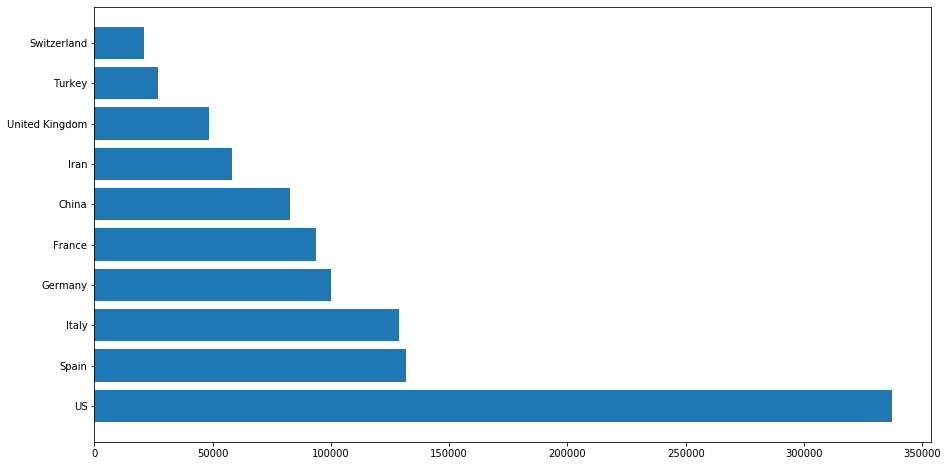

In [83]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(dff['Country/Region'], dff['Confirmed'])

Text(1, 0.4, '05 April 2020')

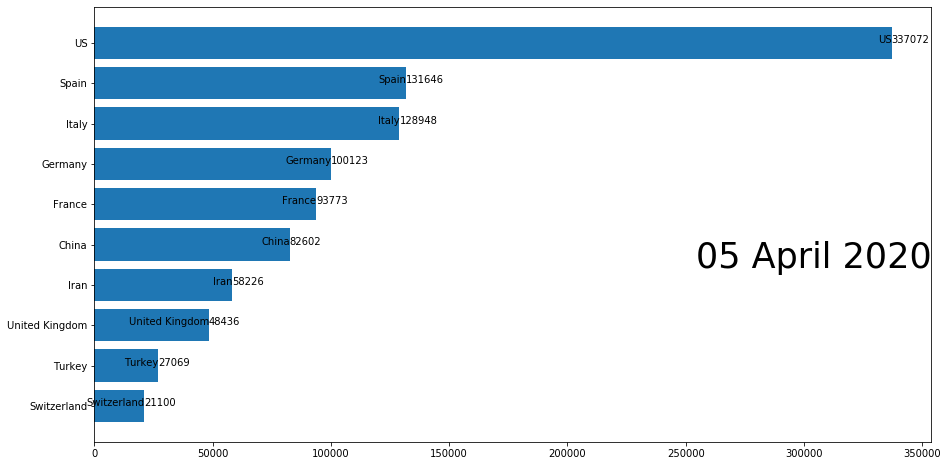

In [96]:
fig, ax = plt.subplots(figsize=(15, 8))
dff = dff[::-1] 
ax.barh(dff['Country/Region'], dff['Confirmed'])
for i, (value, name) in enumerate(zip(dff['Confirmed'], dff['Country/Region'])):
    ax.text(value, i,     name,            ha='right')  # Tokyo: name
    ax.text(value, i,     value,           ha='left')   # 38194.2: value
ax.text(1, 0.4, current_date.strftime("%d %B %Y"), transform=ax.transAxes, size=35, ha='right')

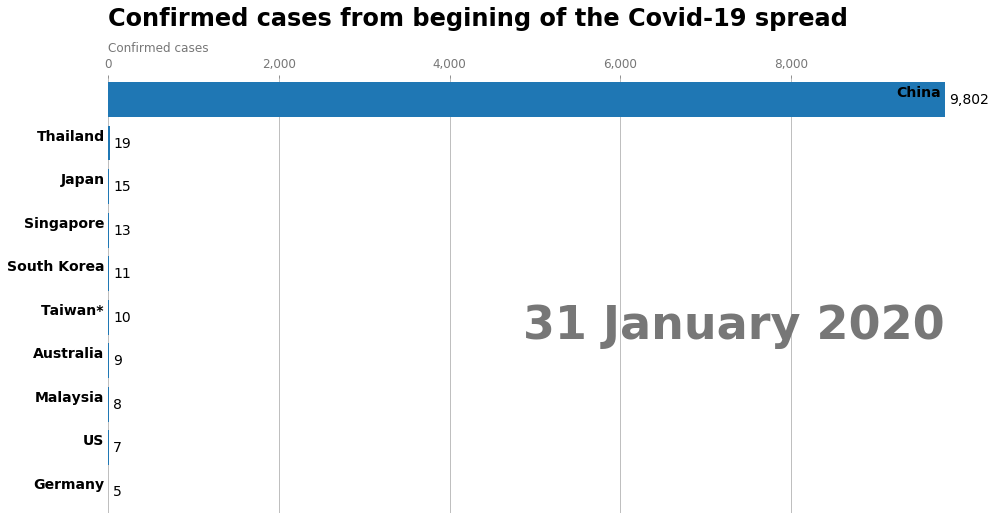

In [129]:
fig, ax = plt.subplots(figsize=(15, 8))

def draw_barchart(date):
    if isinstance(date, int):
        date = datetime.strptime(str(date), '%Y%m%d')
    dff = df[df['Date'].eq(date)].sort_values(by='Confirmed', ascending=True).tail(10)
    ax.clear()
    ax.barh(dff['Country/Region'], dff['Confirmed'])
    dx = dff['Confirmed'].max() / 200
    for i, (value, name) in enumerate(zip(dff['Confirmed'], dff['Country/Region'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.4, date.strftime("%d %B %Y"), transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Confirmed cases', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'Confirmed cases from begining of the Covid-19 spread',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    plt.box(False)
    
draw_barchart(20200131)

In [139]:
begin = df['Date'].min()
end = df['Date'].max()

In [140]:
def daterange(date1, date2):
    for n in range(int((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [141]:
date_range = []
for dt in daterange(begin, end):
    date_range.append(int(dt.strftime("%Y%m%d")))

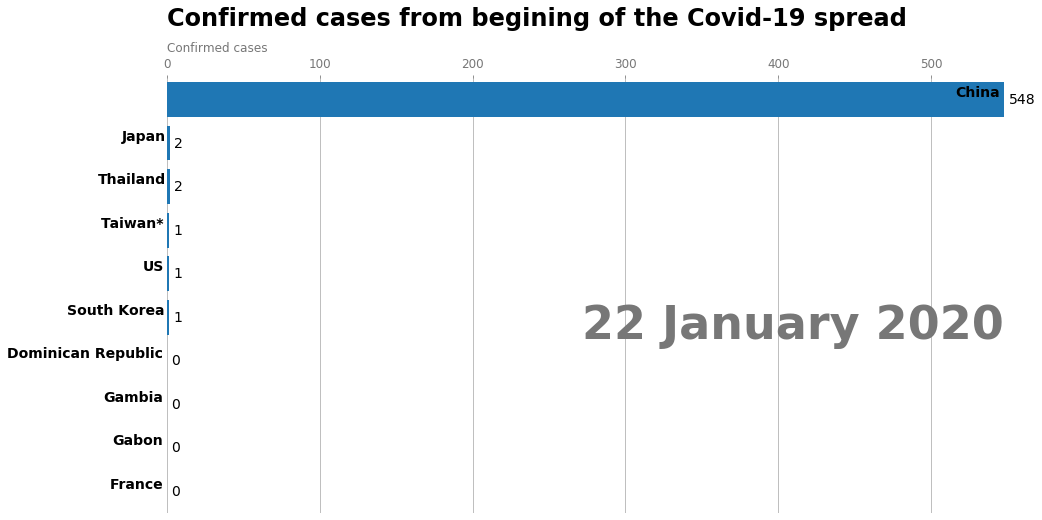

In [142]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=date_range)
HTML(animator.to_jshtml()) 
# or use animator.to_html5_video() or animator.save() 

MovieWriter matplotlib.animation.PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


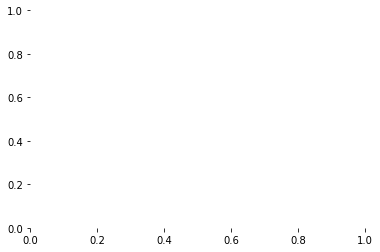

In [147]:
animator.save('Covid19.gif', writer='matplotlib.animation.PillowWriter', fps=2) 